# Smoke Detection Using YOLO V9

Roboflow is a comprehensive library designed to streamline the development and deployment of computer vision models. It offers a wide range of tools and functionalities tailored specifically for handling image data and building robust machine learning pipelines.

In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    

# Import Librares

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import requests
import torch
import random
import matplotlib.pyplot as plt
import shutil
import cv2 as cv
import yaml
import wandb
from IPython.display import Image
from roboflow import Roboflow

# Engine

In [3]:
print(torch.__version__)
!nvidia-smi

2.1.2
Wed May  8 13:04:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------------------

# Dataset

In [4]:
rf = Roboflow(api_key="3O5GpJQtFoHTAf8ybvfT")
project = rf.workspace("vjti-tu8hq").project("csir-7")
version = project.version(4)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to csir-7-4 in yolov9:: 100%|██████████| 1428/1428 [00:00<00:00, 7520.98it/s]


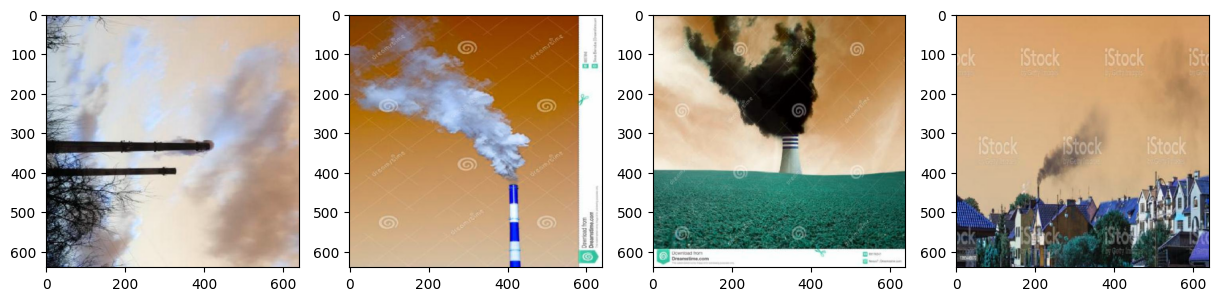

In [5]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
image = cv.imread("/kaggle/working/csir-7-4/train/images/img_384_jpg.rf.d3f008909cc2b489a5a01dd45fbbdfa7.jpg")
ax[0].imshow(image)
image = cv.imread("/kaggle/working/csir-7-4/train/images/img_199_jpg.rf.c25dd33140fa6530c0577ed232fdaaad.jpg")
ax[1].imshow(image)
image = cv.imread("/kaggle/working/csir-7-4/train/images/img_409_jpg.rf.3dbe4195af248450b21404d56312c632.jpg")
ax[2].imshow(image)
image = cv.imread("/kaggle/working/csir-7-4/train/images/img_349_jpg.rf.f76d8e61e959a2becd4ea29515fcc5d1.jpg")
ax[3].imshow(image)
fig.show()

In [6]:
#Cloning the Yolov9 model
!git clone https://github.com/WongKinYiu/yolov9.git

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 668 (delta 222), reused 199 (delta 199), pack-reused 378
Receiving objects: 100% (668/668), 3.22 MiB | 23.75 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [7]:
#Setting the working directory and installing the requirements
%cd yolov9
HOME = os.getcwd()
print(HOME)
!pip install -r requirements.txt

/kaggle/working/yolov9
/kaggle/working/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.0 MB/s eta 0:00:00


In [8]:
#Downloading the weights of model
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-s.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [9]:
#Setting the device
#!nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [10]:
%cd /kaggle/working

/kaggle/working


In [11]:
!ls

__notebook__.ipynb  csir-7-4  yolov9


In [12]:
#Copying the dataset from the input to the working
# Make sure the dataset.yaml is directly inside the datasets folder
!rm -r {HOME}/datasets
source_dir=('csir-7-4')
dest_dir=('yolov9/datasets')
shutil.copytree(source_dir, dest_dir)

rm: cannot remove '/kaggle/working/yolov9/datasets': No such file or directory


'yolov9/datasets'

In [13]:
%cd yolov9

/kaggle/working/yolov9


In [14]:
!ls weights

gelan-c.pt  gelan-e.pt	yolov9-c.pt  yolov9-e.pt


In [15]:
data_yaml = dict(
    train = '/kaggle/working/csir-7-4/train',
    val = '/kaggle/working/csir-7-4/valid',
    nc = 2,
    names = ['Black', 'white']
)


# Note that I am creating the file in the yolov5/data/ directory.
with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [16]:
%cd /kaggle/working/yolov9
%ls

/kaggle/working/yolov9
LICENSE.md     datasets/       models/           train.py         val_triple.py
README.md      detect.py       panoptic/         train_dual.py    weights/
benchmarks.py  detect_dual.py  requirements.txt  train_triple.py
classify/      export.py       scripts/          utils/
data/          figure/         segment/          val.py
data.yaml      hubconf.py      tools/            val_dual.py


In [17]:
%ls weights/

gelan-c.pt  gelan-e.pt  yolov9-c.pt  yolov9-e.pt


In [18]:
%%time
#Training the initial model without changing any default setting
!python train.py  --img 512 --batch 16 --epochs 100 --data data.yaml --weights weights/gelan-e.pt --cache --device 0,1 --sync-bn --close-mosaic 15 --cfg models/detect/gelan-e.yaml --name gelan-e-initial --cfg models/detect/gelan-e.yaml --hyp hyp.scratch-high.yaml

2024-05-08 13:04:50.692285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 13:04:50.692433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 13:04:50.832889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=weights/gelan-e.pt, cfg=models/detect/gelan-e.yaml, data=data.yaml, hyp=hyp.scratch-high.yaml, epochs=100, batch_size=16, imgsz=512, rect=False, resume=

In [3]:
import cv2 as cv
from IPython.display import Image

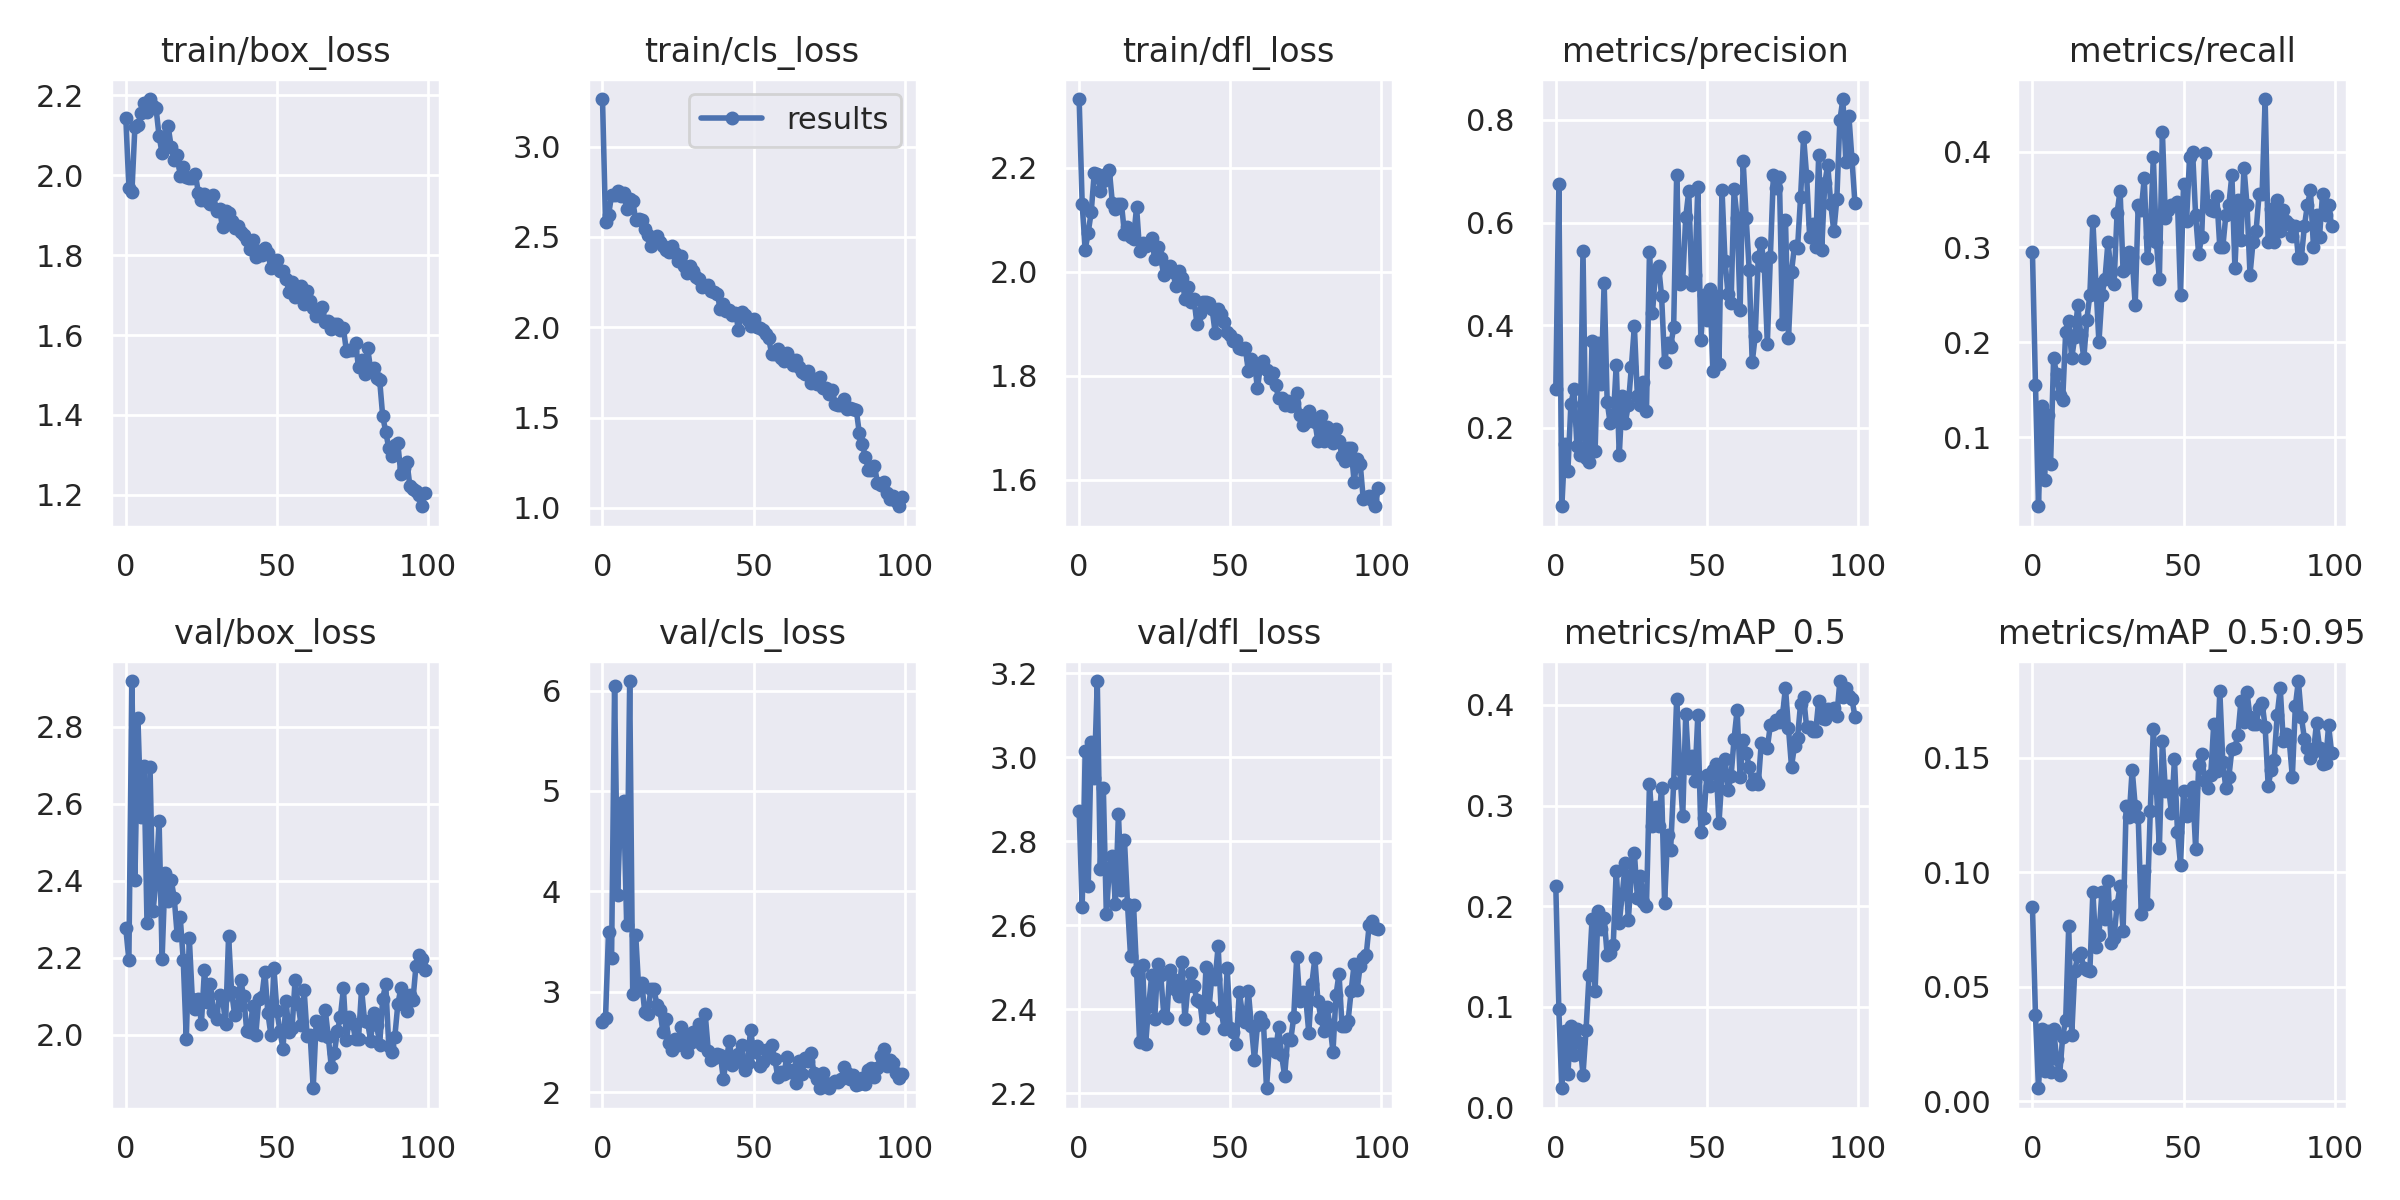

In [4]:
#Plotting the confusion matrix for the best model
Image(filename="results.png", width=1280)

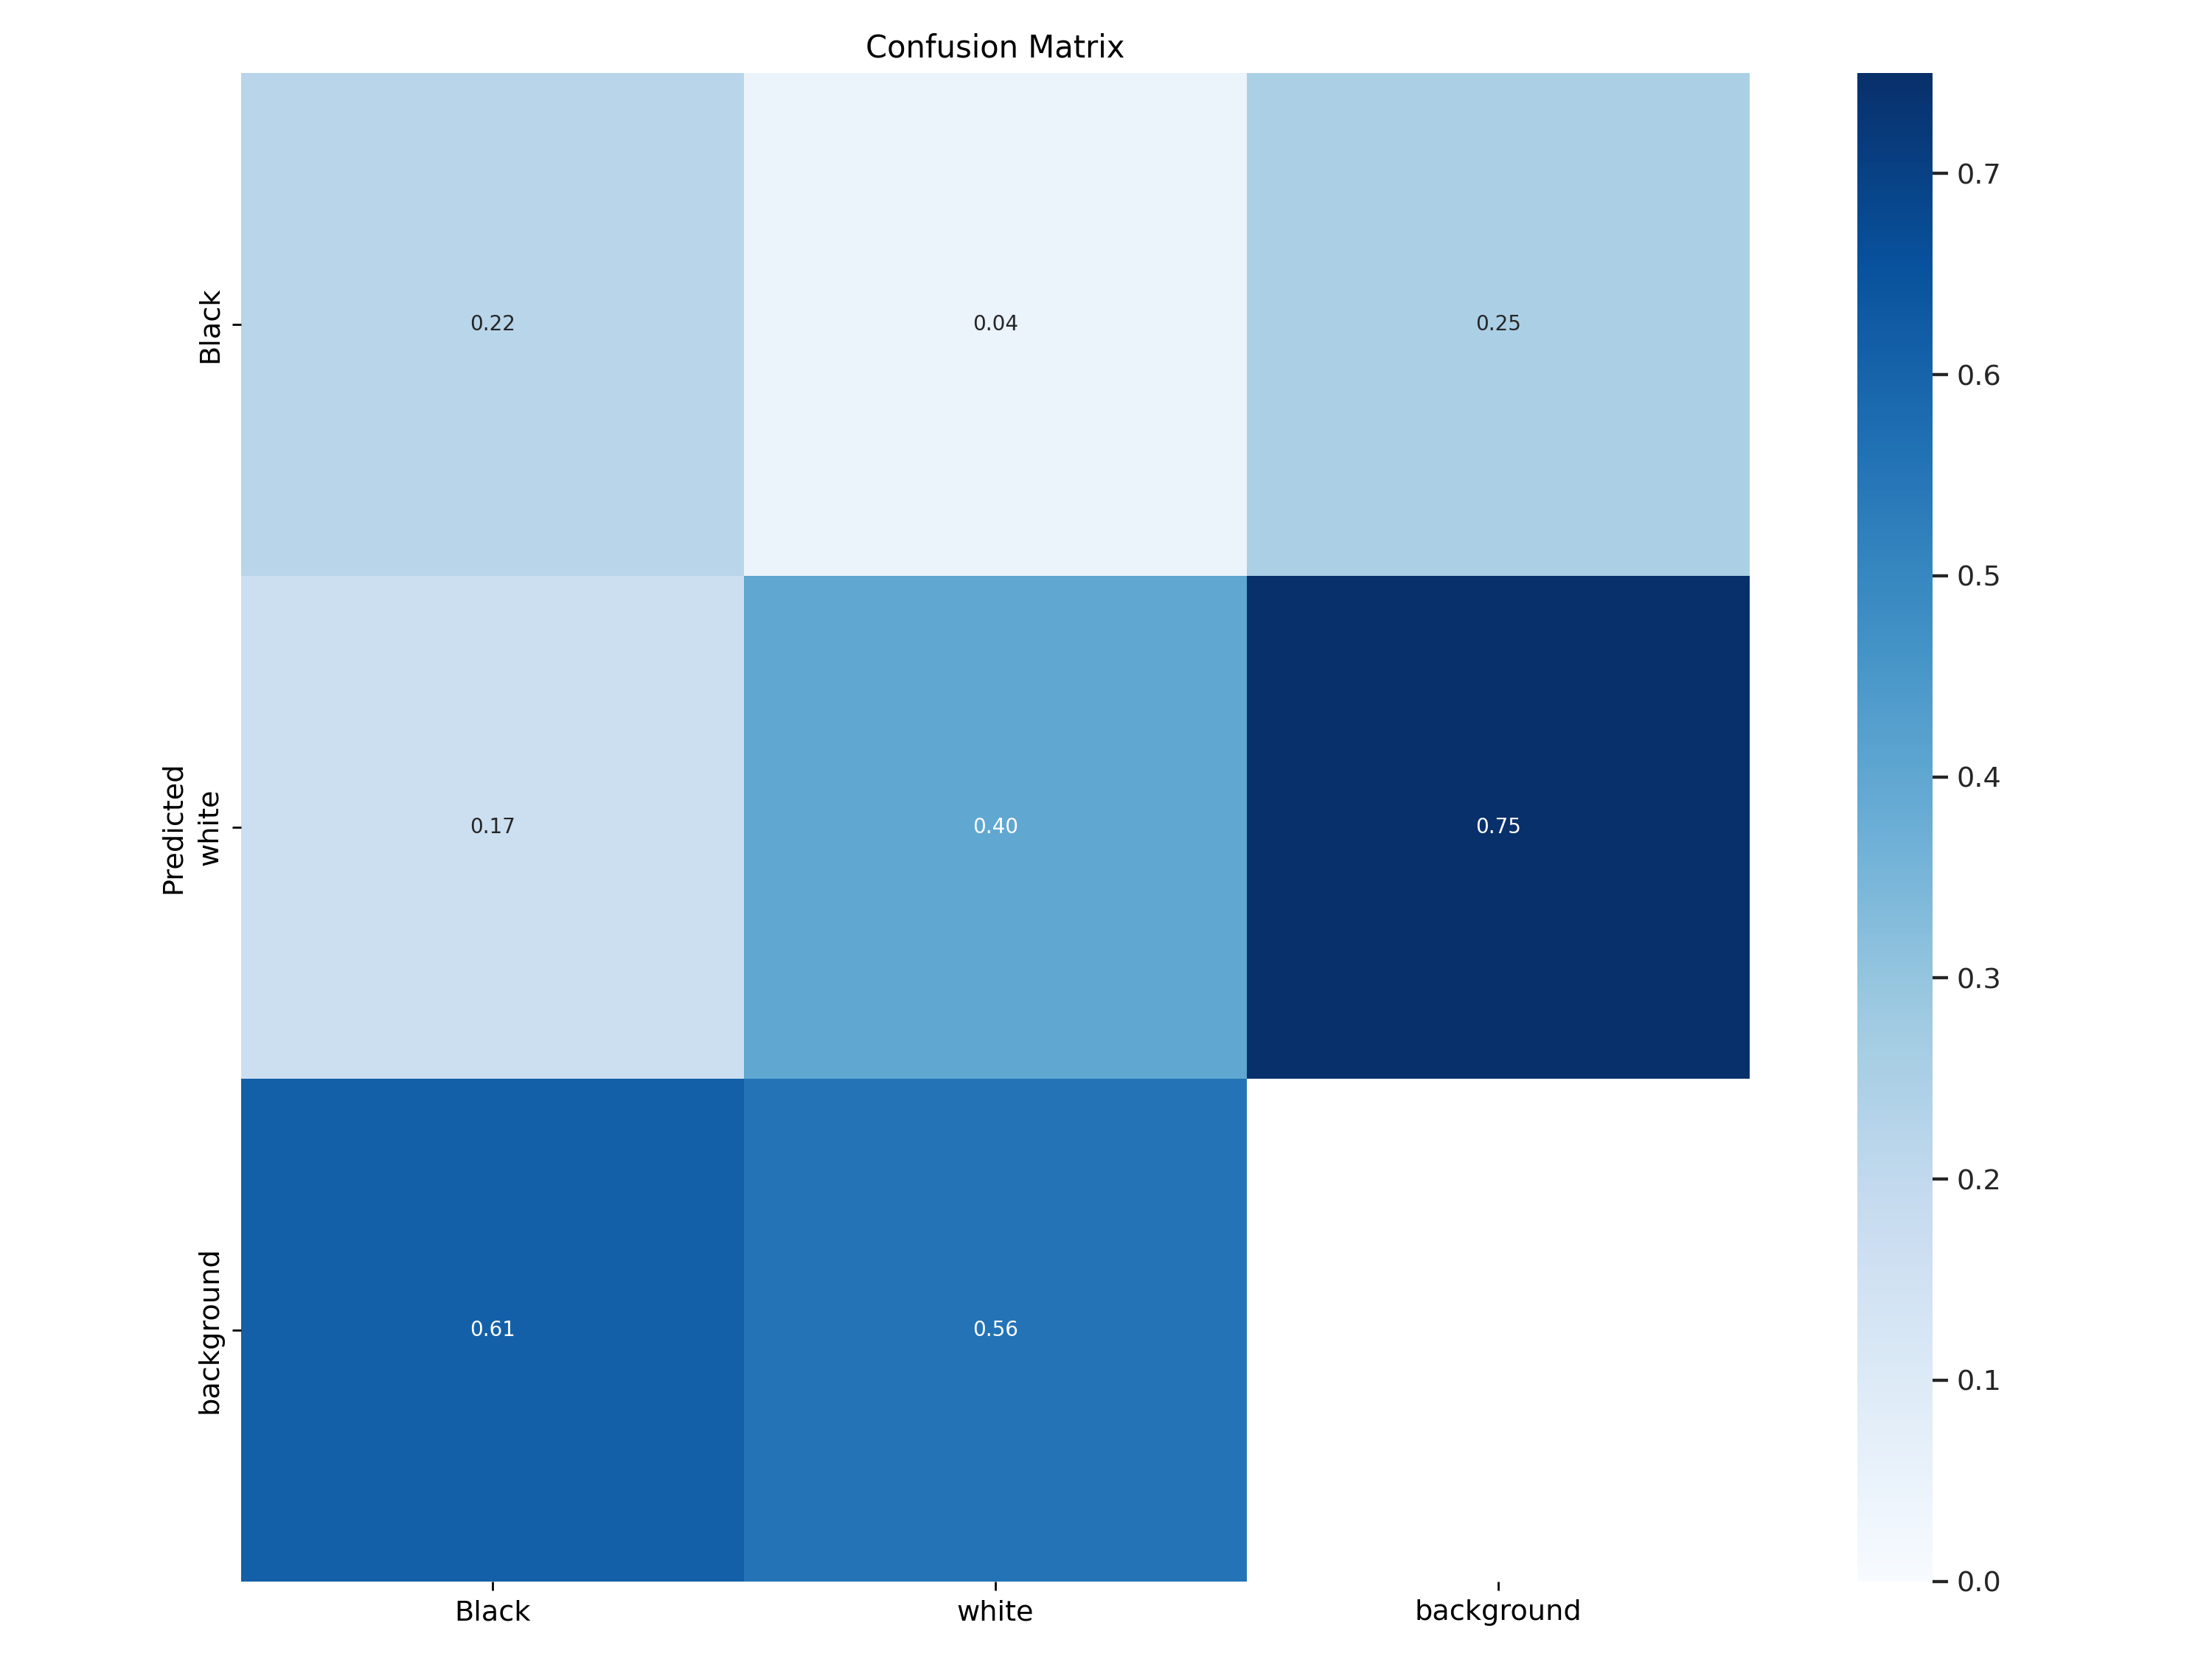

In [5]:
#Plotting the confusion matrix for the best model
Image(filename="confusion_matrix.png", width=1280)

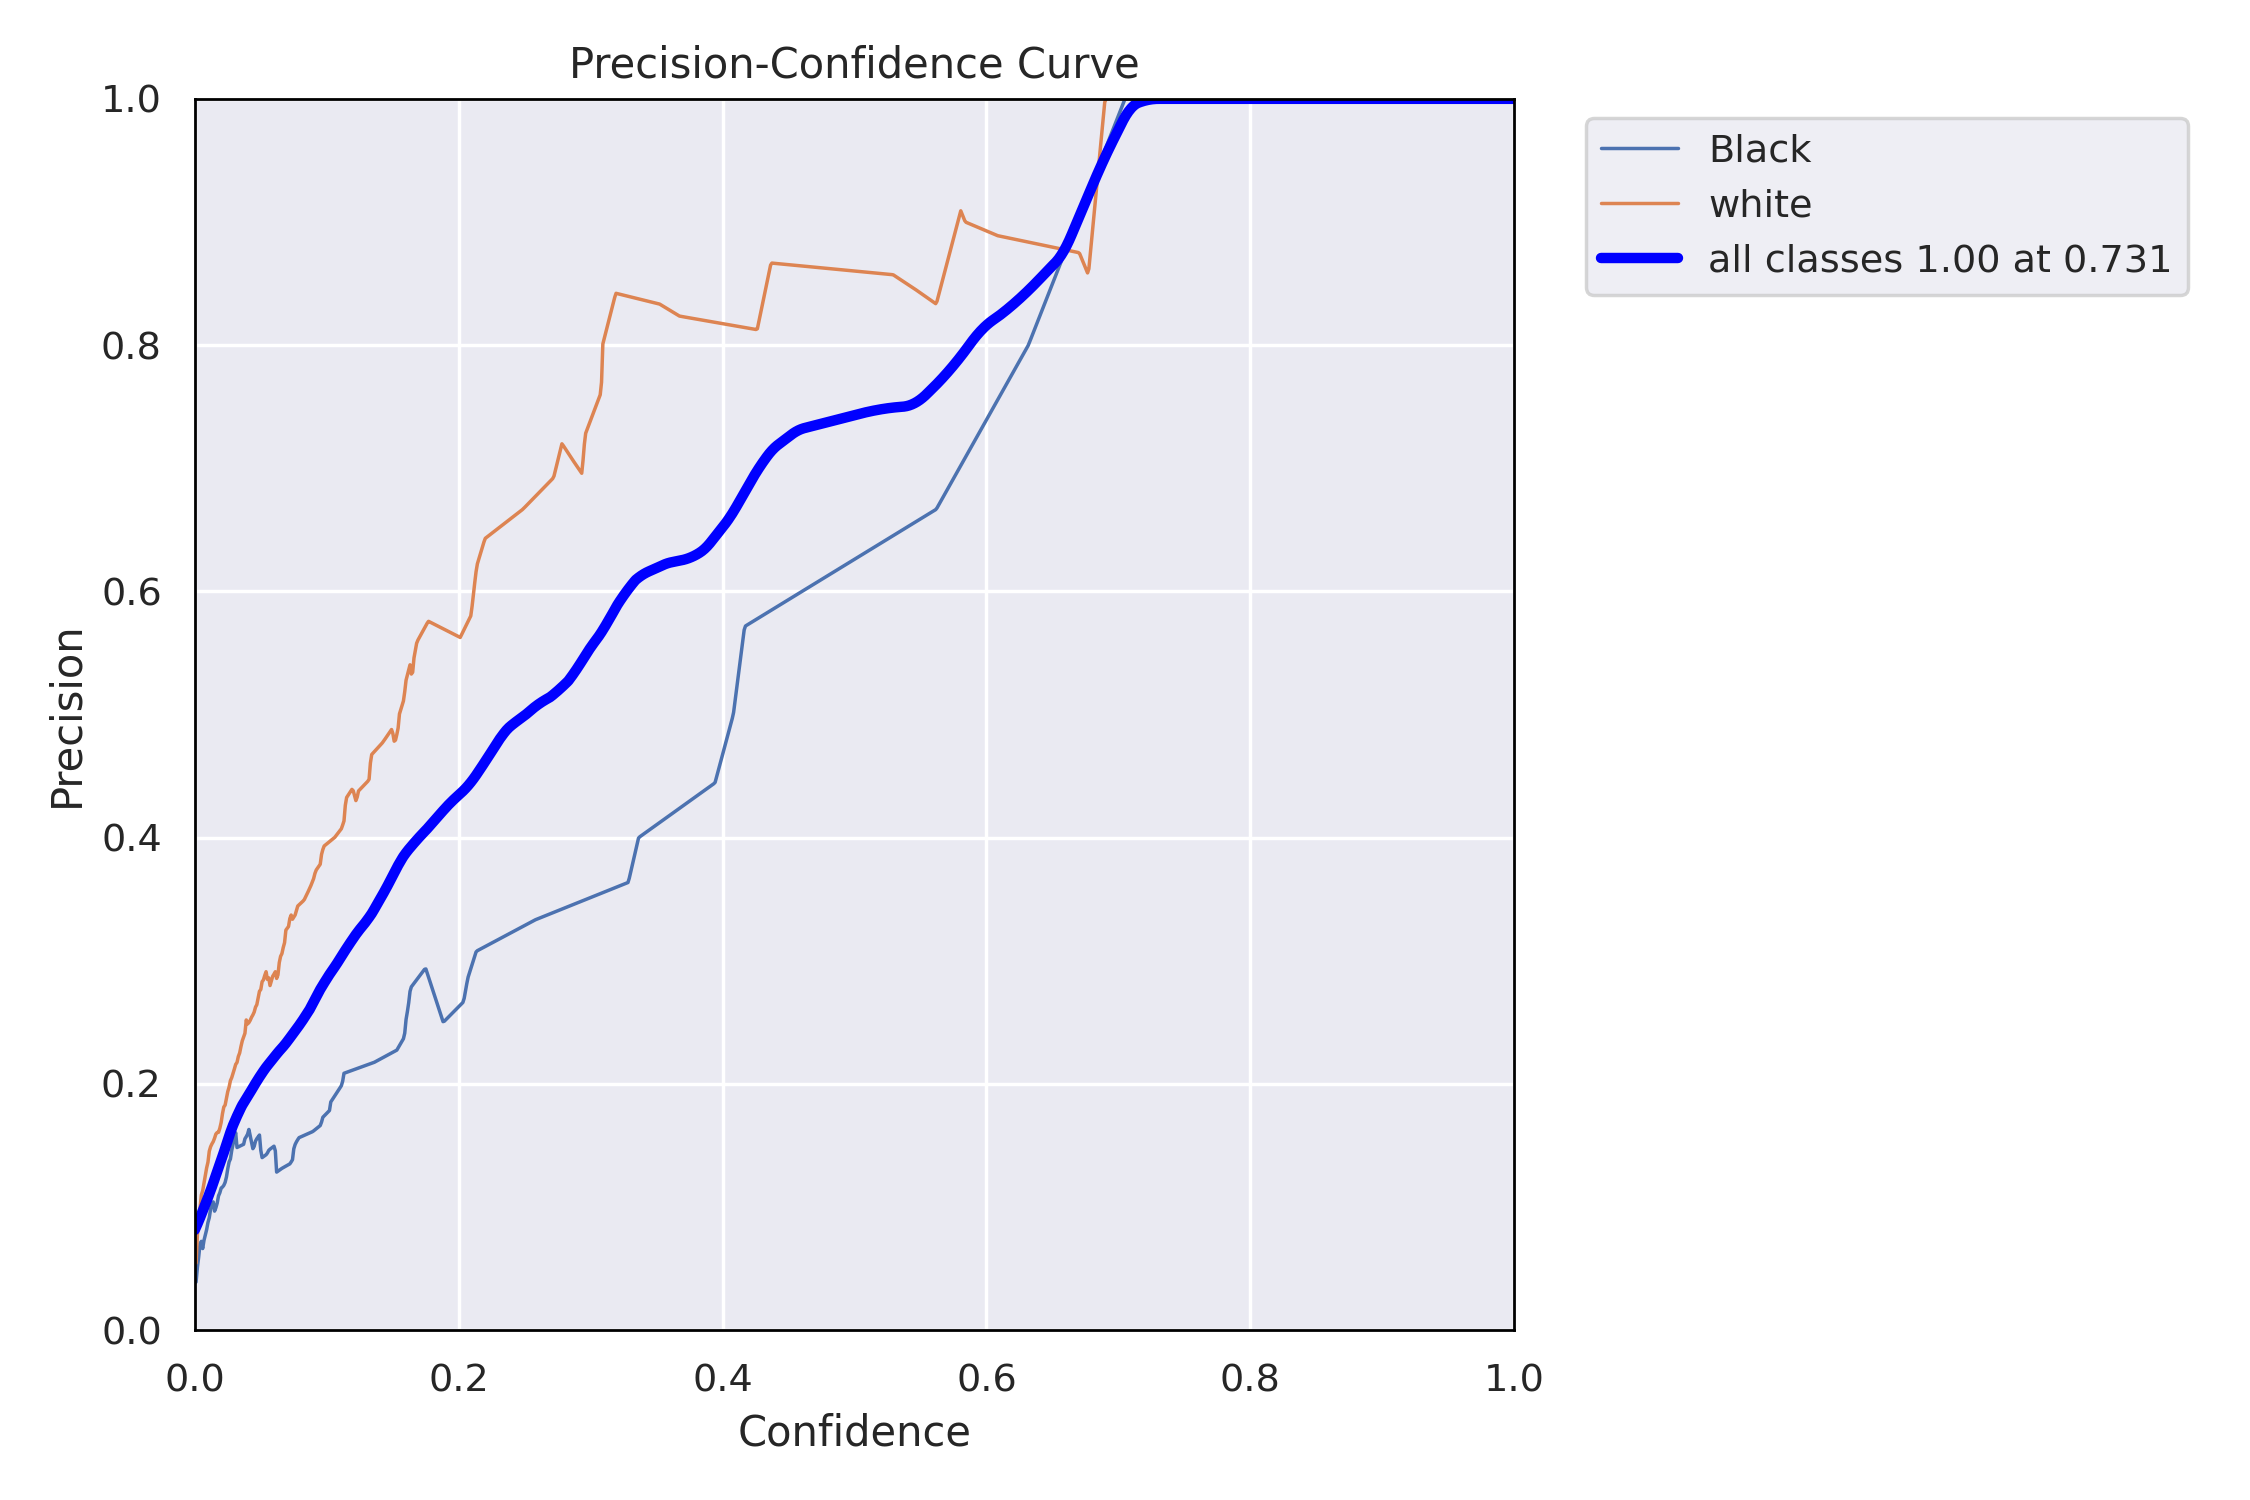

In [7]:
#Plotting the confusion matrix for the best model
Image(filename="P_curve.png", width=1280)

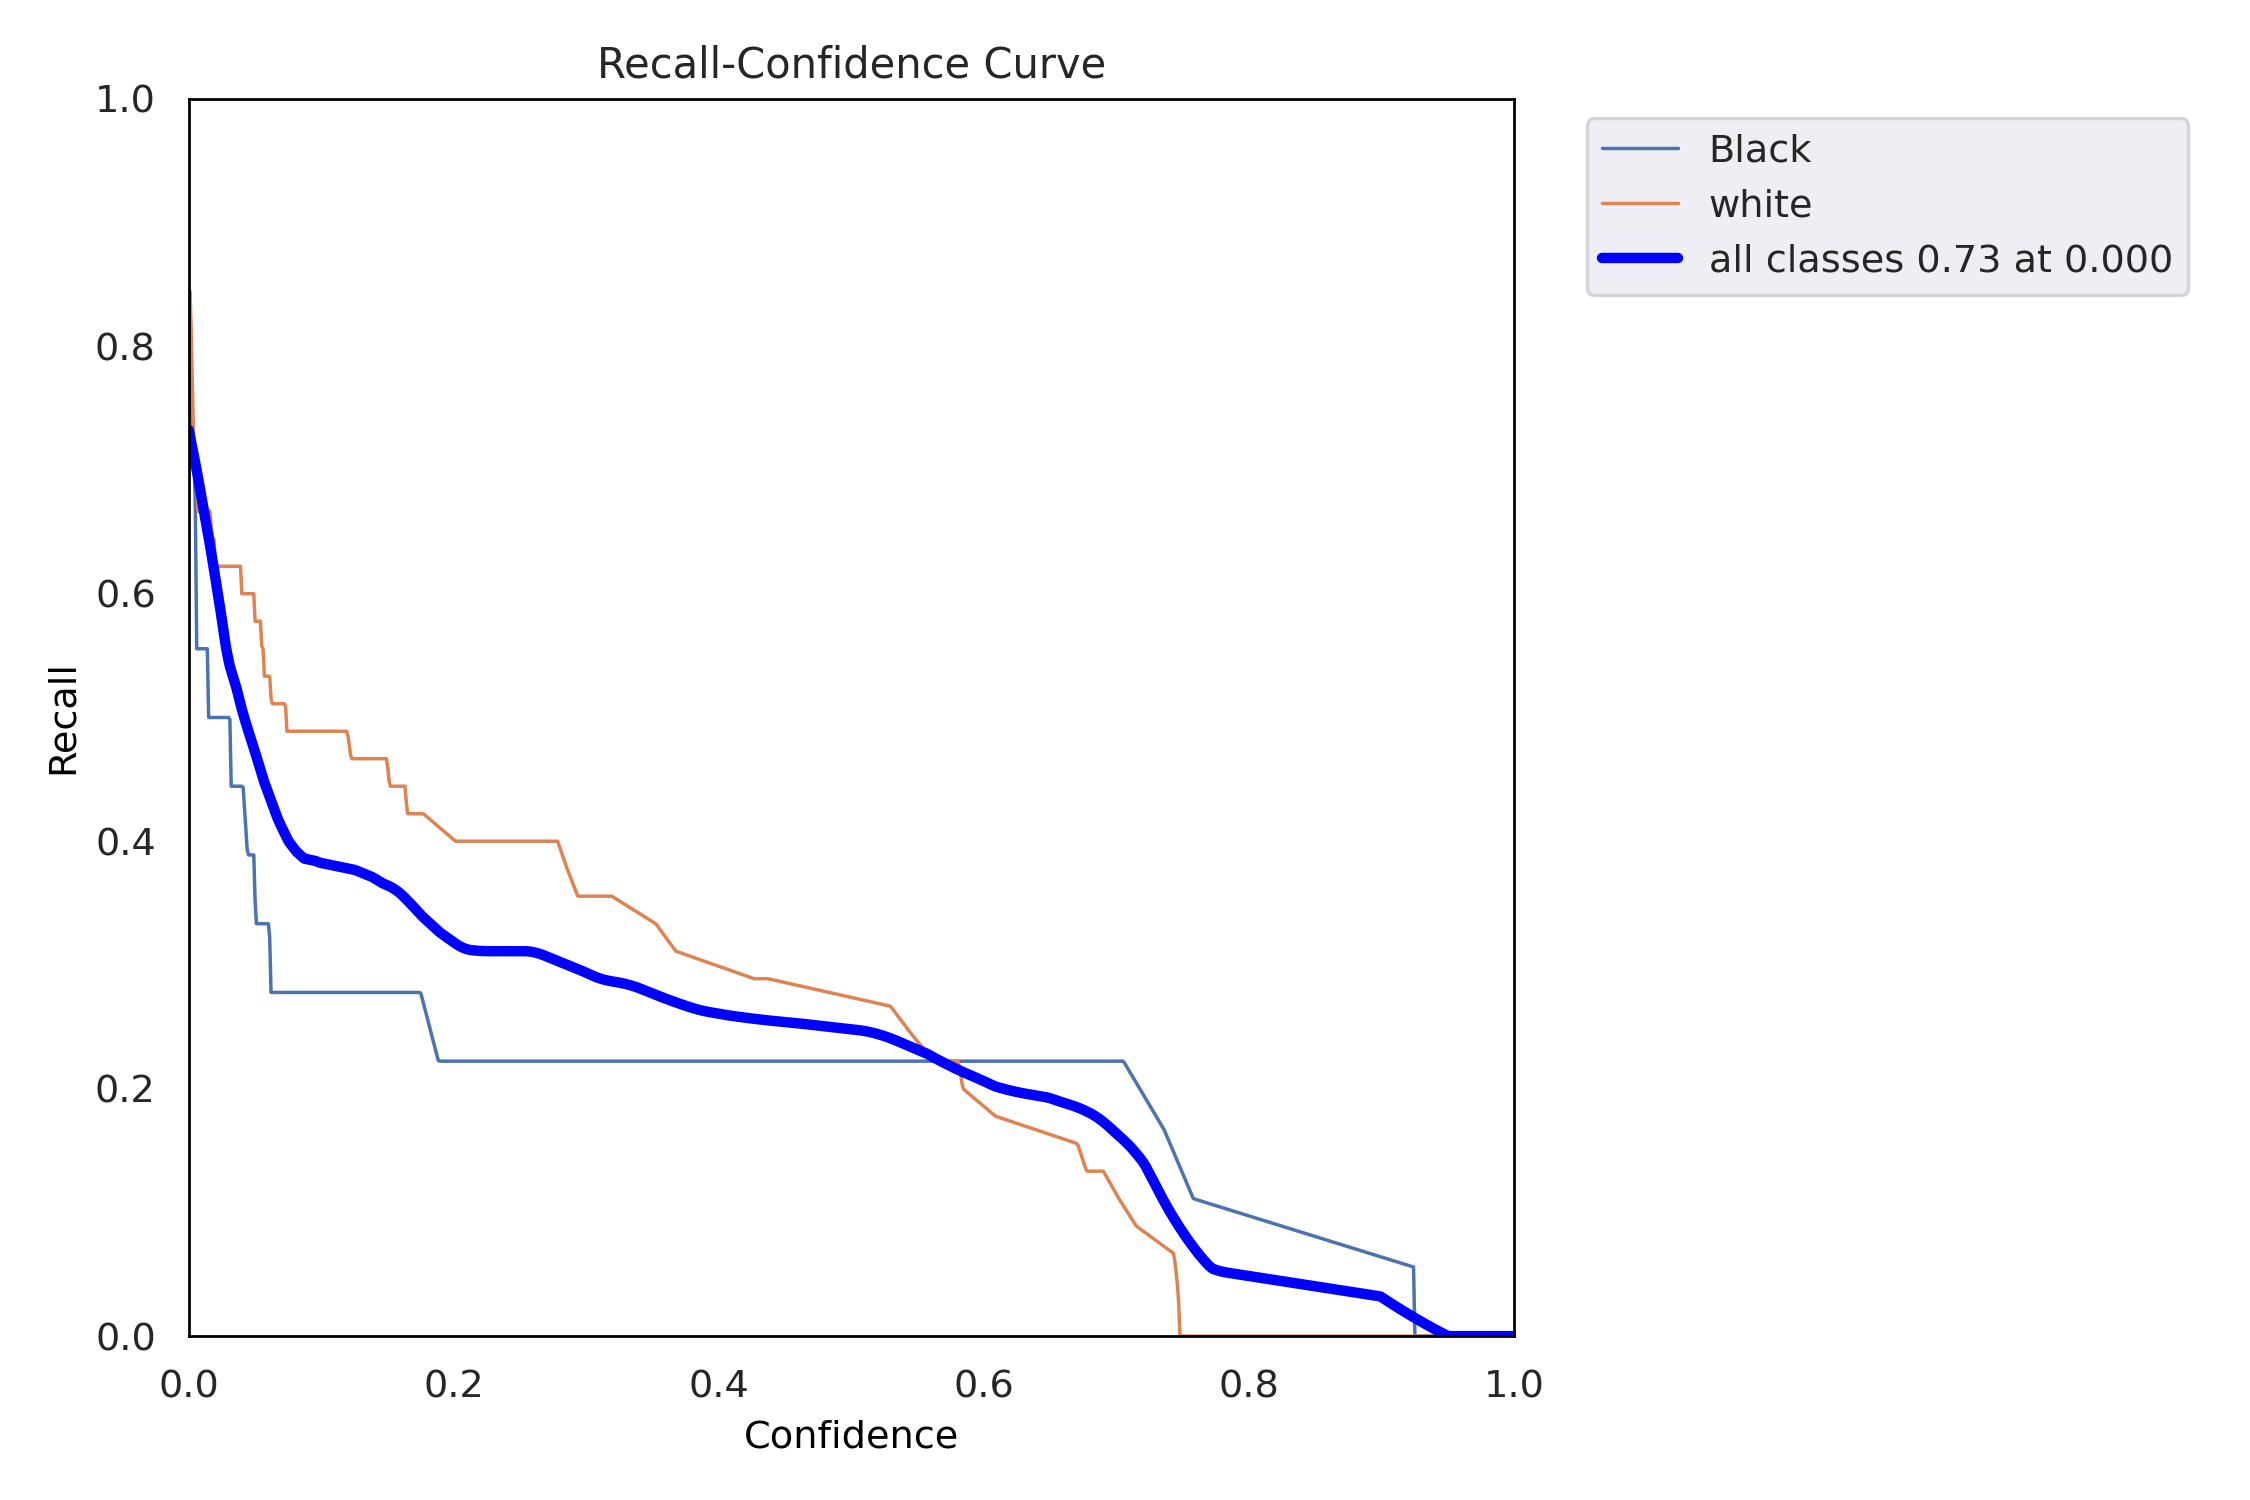

In [8]:
#Plotting the confusion matrix for the best model
Image(filename="R_curve.png", width=1280)